In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('train_x_df.csv', parse_dates=True)
df.head(5)

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


In [20]:
df_train_x = df.set_index("sample_id")
df_train_x

,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
sample_id,,,,,,,,,,,
0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...
7660,1375,8,1.000277,1.000499,1.000000,1.000388,0.574281,103.592369,0.665410,0.266649,48.100475
7660,1376,8,1.000333,1.000388,0.999834,1.000277,1.350429,243.535217,0.804037,0.487857,87.985291
7660,1377,8,1.000277,1.000388,0.999834,1.000277,0.692170,124.846756,0.781857,0.360461,65.018936


In [21]:
x_train = []
for idx in sorted(list(set(df_train_x.index))):
    temp = df_train_x.loc[idx]
    
#     temp_open      = temp['open']
    temp_high      = temp['high']
#     temp_low       = temp['low']
#     temp_close     = temp['close']
    temp_volume    = temp['volume']
    temp_quote_av  = temp['quote_av']
    temp_trades    = temp['trades']
    temp_tb_base_av  = temp['tb_base_av']
    temp_tb_quote_av = temp['tb_quote_av']

    encode    = np.zeros(10)
    encode[temp["coin_index"].iloc[0]] = 1

#         x_temp = np.concatenate((encode,fft_open,fft_high,fft_low,fft_close,fft_volume,fft_quote_av,fft_trades,fft_tb_base_av,fft_tb_quote_av), axis =  None)
    x_temp = np.concatenate((temp_high,temp_volume,temp_quote_av,temp_trades,temp_tb_base_av,temp_tb_quote_av), axis =  None)
    x_train.append(x_temp)

In [22]:
np.shape(x_train)

(7661, 8280)

In [23]:
df_train_y = pd.read_csv('train_y_df.csv', parse_dates=True)
df_train_y = df_train_y.set_index("sample_id")

In [24]:
y_train = []
for idx in sorted(list(set(df_train_y.index))):
    temp = df_train_y.loc[idx]
    y_train.append(temp["high"])

In [25]:
np.shape(y_train)

(7661, 120)

In [26]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


x_train = ss.fit_transform(x_train)
y_train = mm.fit_transform(y_train) 

In [28]:
print("Training Shape", x_train.shape, y_train.shape)

Training Shape (7661, 8280) (7661, 120)


In [29]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
import tqdm
import torch.nn.functional as F
from torch.nn import Linear, Sequential
from torch.nn import LeakyReLU
from torch.nn import Module

In [30]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)

True
학습을 진행하는 기기: cuda:0


In [31]:
x_train_tensors = Variable(torch.Tensor(x_train))
y_train_tensors = Variable(torch.Tensor(y_train))

In [32]:
#reshaping to rows, timestamps, features
x_train_tensors_final = torch.reshape(x_train_tensors,   (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
x_train_tensors_final = x_train_tensors

In [33]:
print("Training Shape", x_train_tensors_final.shape, y_train_tensors.shape) 

Training Shape torch.Size([7661, 8280]) torch.Size([7661, 120])


In [12]:
class ActiveDropout(Module):
    # all building blocks of networks are inherited from Module!

    def __init__(self, p=0.5):
        super().__init__()  # init the base class
        self.p = p

    def forward(self, input):
        mask = torch.rand_like(input) > self.p
        return input * mask.to(input) / (1 - self.p)


        pass

In [2]:
def build_model1(p=0.5):
    """Build a model with dropout layers' rate set to `p`."""

    return Sequential(
        ## Exercise: Use `ActiveDropout` before linear layers of our
        #  first network. Note that dropping out inputs is not a good idea

        Linear(8280, 2120, bias=True),
        LeakyReLU(),

#         ActiveDropout(p),
#         Linear(16560, 8280, bias=True),
#         LeakyReLU(),

        ActiveDropout(p),
        Linear(2120, 1060, bias=True),
        LeakyReLU(),
        
        ActiveDropout(p),
        Linear(1060, 360, bias=True),
        LeakyReLU(),
        
        ActiveDropout(p),
        Linear(360, 120, bias=True),
        # pass
    )

In [36]:
def build_model2(p=0.5):
    """Build a model with dropout layers' rate set to `p`."""

    return Sequential(
        ## Exercise: Use `ActiveDropout` before linear layers of our
        #  first network. Note that dropping out inputs is not a good idea

        Linear(8280, 1000, bias=True),
        LeakyReLU(),
        
        ActiveDropout(p),
        Linear(1000, 360, bias=True),
        LeakyReLU(),
        
        ActiveDropout(p),
        Linear(360, 120, bias=True),
        # pass
    )

In [37]:
BNN = build_model1(p=0.5)
BNN.to(device)

Sequential(
  (0): Linear(in_features=8280, out_features=2120, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): ActiveDropout()
  (3): Linear(in_features=2120, out_features=1060, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): ActiveDropout()
  (6): Linear(in_features=1060, out_features=360, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): ActiveDropout()
  (9): Linear(in_features=360, out_features=120, bias=True)
)

In [38]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.0001 #0.001 lr

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(BNN.parameters(), lr=learning_rate)

In [39]:
for epoch in range(num_epochs):
    outputs = BNN.forward(x_train_tensors_final.to(device)) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors.to(device))

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.22784
Epoch: 100, loss: 0.01968
Epoch: 200, loss: 0.01201
Epoch: 300, loss: 0.00941
Epoch: 400, loss: 0.00806
Epoch: 500, loss: 0.00681
Epoch: 600, loss: 0.00597
Epoch: 700, loss: 0.00526
Epoch: 800, loss: 0.00475
Epoch: 900, loss: 0.00437


In [24]:
def point_estimate(model, dataset, n_samples=1, verbose=False):
    """Draw pointwise samples with stochastic forward pass."""

    outputs = []
    for sample in tqdm.tqdm(range(n_samples), disable=not verbose):

        outputs.append(BNN(dataset))

    return torch.stack(outputs, dim=0)


samples = point_estimate(BNN, x_train_tensors_final[100].to(device), n_samples=101, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 1807.54it/s]


In [75]:
samples.shape

torch.Size([101, 120])

NameError: name 'samples' is not defined

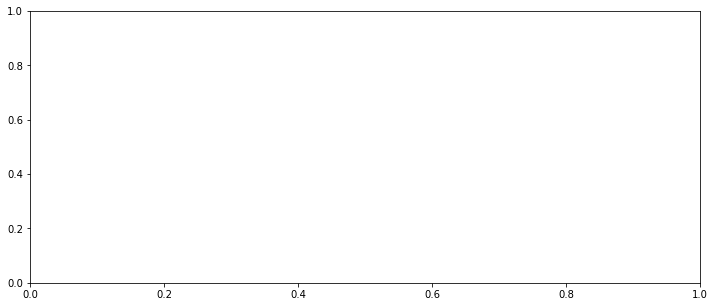

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

mean, std = samples.mean(dim=0).cpu().detach().numpy(), samples.std(dim=0).cpu().detach().numpy()
ax.plot(y_train_tensors[100], label = 'Real')
ax.plot(mean + 1.96 * std, c="b", label = '+95%')
ax.plot(mean - 1.96 * std, c="b", label = '-95%');
ax.plot(mean, c="r", label = 'mean');
plt.legend()

In [40]:
torch.save(BNN.state_dict(),'./BNN.pth')

In [3]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
import tqdm
import torch.nn.functional as F
from torch.nn import Linear, Sequential
from torch.nn import LeakyReLU
from torch.nn import Module

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)

True
학습을 진행하는 기기: cuda:0


In [21]:
BNN = build_model1()
BNN.load_state_dict(torch.load('./BNN.pth'), strict=False)

<All keys matched successfully>

In [22]:
df_test_x = pd.read_csv('test_x_df.csv', parse_dates=True)
df_test_x = df_test_x.set_index("sample_id")
df_test_x

,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
sample_id,,,,,,,,,,,
7661,0,7,0.993560,0.993560,0.990477,0.991021,587512.625000,534685.312500,553.533691,76317.687500,69457.835938
7661,1,7,0.990771,0.993048,0.990357,0.992689,616675.437500,560815.937500,514.306885,291661.375000,265331.843750
7661,2,7,0.992710,0.993560,0.991316,0.991795,670641.687500,610829.625000,361.758240,288066.125000,262389.562500
7661,3,7,0.992318,0.992318,0.990695,0.990727,365400.343750,332430.937500,329.069244,113585.000000,103350.929688
7661,4,7,0.991141,0.991152,0.989158,0.989605,245272.531250,222917.734375,481.617889,70405.781250,63988.847656
...,...,...,...,...,...,...,...,...,...,...,...
8195,1375,6,0.997053,0.999276,0.997053,0.999069,1.633000,315.307526,1.375175,0.878884,169.736862
8195,1376,6,0.999121,1.000569,0.998552,1.000569,1.478406,285.818695,1.039136,0.455307,88.052055
8195,1377,6,1.000569,1.001086,0.999121,0.999690,0.848792,164.188950,0.935739,0.445028,86.055450


In [23]:
x_test = []
for idx in sorted(list(set(df_test_x.index))):
    temp = df_test_x.loc[idx]
    
#     temp_open      = temp['open']
    temp_high      = temp['high']
#     temp_low       = temp['low']
#     temp_close     = temp['close']
    temp_volume    = temp['volume']
    temp_quote_av  = temp['quote_av']
    temp_trades    = temp['trades']
    temp_tb_base_av  = temp['tb_base_av']
    temp_tb_quote_av = temp['tb_quote_av']

    encode    = np.zeros(10)
    encode[temp["coin_index"].iloc[0]] = 1

#         x_temp = np.concatenate((encode,fft_open,fft_high,fft_low,fft_close,fft_volume,fft_quote_av,fft_trades,fft_tb_base_av,fft_tb_quote_av), axis =  None)
    x_temp = np.concatenate((temp_high,temp_volume,temp_quote_av,temp_trades,temp_tb_base_av,temp_tb_quote_av), axis =  None)
    x_test.append(x_temp)

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

In [25]:
x_test = np.array(x_test)
x_test = ss.fit_transform(x_test)
x_test_tensors = Variable(torch.Tensor(x_test))
x_test_tensors_final = torch.reshape(x_test_tensors,   (x_test_tensors.shape[0], 1, x_test_tensors.shape[1]))
print("Training Shape", x_test_tensors_final.shape) 

Training Shape torch.Size([535, 1, 8280])


In [26]:
torch.cuda.empty_cache()

In [27]:
def point_estimate(model, dataset, n_samples=1, verbose=False):
    """Draw pointwise samples with stochastic forward pass."""

    outputs = []
    for sample in tqdm.tqdm(range(n_samples), disable=not verbose):

        outputs.append(BNN(dataset))

    return torch.stack(outputs, dim=0)

In [29]:
test_predict = point_estimate(BNN, x_test_tensors_final, n_samples=1000, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.79it/s]


In [47]:
test_predict[0][0].shape

torch.Size([1, 120])

In [30]:
test_mean, test_std = test_predict.mean(dim=0).cpu().detach().numpy(), test_predict.std(dim=0).cpu().detach().numpy()
print(test_mean.shape)
print(test_std.shape)

(535, 1, 120)
(535, 1, 120)


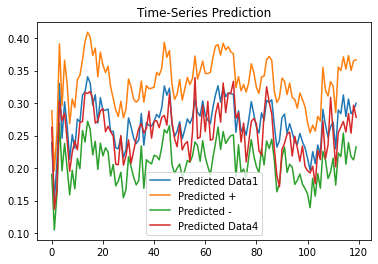

In [51]:
plt.plot(test_mean[0][0], label='Predicted Data1') #predicted plot
plt.plot(test_mean[0][0] + 1.96*test_std[0][0], label='Predicted +')
plt.plot(test_mean[0][0] - 1.96*test_std[0][0], label='Predicted -')
plt.plot(test_predict[0][0][0].cpu().detach().numpy(), label='Predicted Data4') #predicted plot


plt.title('Time-Series Prediction')
plt.legend()
plt.show()

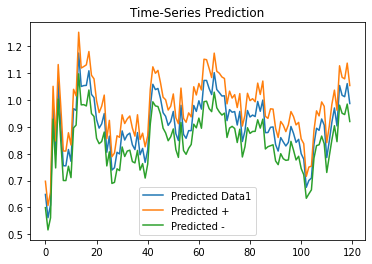

In [32]:
plt.plot(test_mean[10][0], label='Predicted Data1') #predicted plot
plt.plot(test_mean[10][0] + 1.96*test_std[0][0], label='Predicted +')
plt.plot(test_mean[10][0] - 1.96*test_std[0][0], label='Predicted -')

plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [39]:
test_std[0]

array([[0.02502936, 0.02315707, 0.02439951, 0.0311172 , 0.02556765,
        0.03266887, 0.03305148, 0.02799122, 0.02799429, 0.03179825,
        0.03093443, 0.03662645, 0.02765558, 0.03944121, 0.03492581,
        0.03616911, 0.03899483, 0.03652314, 0.03638273, 0.03565944,
        0.03556878, 0.02953115, 0.03351933, 0.03503316, 0.02591521,
        0.02983399, 0.0253308 , 0.02783404, 0.0313408 , 0.03158245,
        0.0305206 , 0.03128105, 0.03055714, 0.03241147, 0.03180549,
        0.02540673, 0.03383914, 0.02905365, 0.028865  , 0.02970338,
        0.02670205, 0.03297098, 0.03317196, 0.03096111, 0.03427044,
        0.02972404, 0.02940566, 0.03145143, 0.0291172 , 0.02904455,
        0.03320644, 0.03032376, 0.03195282, 0.03259704, 0.03046676,
        0.03045047, 0.03368355, 0.02615513, 0.0355305 , 0.0312113 ,
        0.03287294, 0.03637876, 0.04029575, 0.03937607, 0.03811914,
        0.03232872, 0.03705192, 0.03464471, 0.03675375, 0.03616165,
        0.03284544, 0.03186042, 0.03503739, 0.02

In [37]:
test_mean[0]*(1/test_std[0])

array([[ 9.550685 ,  6.4886465,  8.482557 , 10.606541 ,  9.609722 ,
         9.2400875,  8.018126 ,  7.6290383,  8.983196 ,  7.2456884,
         8.89887  ,  7.394921 , 11.282622 ,  8.04515  ,  9.746432 ,
         9.14596  ,  7.609492 ,  8.565538 ,  7.3974557,  8.645748 ,
         8.10987  ,  9.787618 ,  8.674804 ,  7.315995 ,  9.8975   ,
         7.743886 ,  9.063808 ,  8.915412 ,  6.8839927,  7.242958 ,
         9.080986 ,  8.417618 ,  8.049662 ,  7.3342123,  7.644619 ,
        11.172943 ,  6.949379 ,  9.286886 ,  9.197099 ,  8.908871 ,
        10.185368 ,  8.569953 ,  8.370616 ,  9.462714 ,  9.520469 ,
        10.49955  , 10.982916 ,  8.496994 ,  8.534146 ,  8.841686 ,
         8.167919 ,  8.075922 ,  8.106858 ,  8.454774 ,  8.815034 ,
         9.130309 ,  9.090424 , 10.921711 ,  7.880678 ,  9.716899 ,
         8.562673 ,  7.5275435,  6.6578546,  7.442666 ,  8.203803 ,
        10.101988 ,  8.132424 ,  9.354045 ,  8.428637 ,  8.727139 ,
         9.567066 ,  9.836341 ,  7.278884 , 10.7

array([[0.00062647, 0.00053625, 0.00059534, 0.00096828, 0.0006537 ,
        0.00106726, 0.0010924 , 0.00078351, 0.00078368, 0.00101113,
        0.00095694, 0.0013415 , 0.00076483, 0.00155561, 0.00121981,
        0.0013082 , 0.0015206 , 0.00133394, 0.0013237 , 0.0012716 ,
        0.00126514, 0.00087209, 0.00112355, 0.00122732, 0.0006716 ,
        0.00089007, 0.00064165, 0.00077473, 0.00098225, 0.00099745,
        0.00093151, 0.0009785 , 0.00093374, 0.0010505 , 0.00101159,
        0.0006455 , 0.00114509, 0.00084411, 0.00083319, 0.00088229,
        0.000713  , 0.00108709, 0.00110038, 0.00095859, 0.00117446,
        0.00088352, 0.00086469, 0.00098919, 0.00084781, 0.00084359,
        0.00110267, 0.00091953, 0.00102098, 0.00106257, 0.00092822,
        0.00092723, 0.00113458, 0.00068409, 0.00126242, 0.00097415,
        0.00108063, 0.00132341, 0.00162375, 0.00155047, 0.00145307,
        0.00104515, 0.00137284, 0.00120026, 0.00135084, 0.00130766,
        0.00107882, 0.00101509, 0.00122762, 0.00

In [62]:
for i in range(len(test_mean)):
    print(np.argmax(test_mean[0]*(1/test_std[0])))

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
1

In [61]:
for i in range(len(test_mean)):
    print(np.argmax(test_mean[0]*(1/test_std[0]*test_std[0])))

14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
1